<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/05_divergent_transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. サンプリングがうまくいかない場合の例
* 密度関数が非常にpeakyであるとき、サンプリングが上手くいかないことがある。
 * peakyになっている部分が、サンプリングによって全くカバーされなかったりする。
* この場合、reparameterizationを使うと、問題が解決することがある。
 * https://mc-stan.org/docs/2_26/stan-users-guide/reparameterization-section.html

## 5.0 準備

In [ ]:
!pip install arviz==0.10
!pip install pymc3==3.10

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 20210328

## 5.1 サンプリングがうまく行かない理由
* 参考資料
 * https://mc-stan.org/docs/2_26/reference-manual/divergent-transitions.html
* HMCは、勾配を使ってfirst-orderの近似を行っているため、"地形が急峻な"場所では、本当に求めたいものから大きく外れてしまうことがある。すると、サンプリングがパラメータ空間内での単なるランダムウォークに近くなってしまい、密度関数の"濃淡"を反映しないものになってしまう。
 * 別の参考資料 https://norimune.net/3149

## 5.2 モデル
* 下のような確率分布を考える。
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* 同時分布を式で書くと・・・
$$p(y, x_1, \ldots, x_9) = p(y) \prod_{i=1}^9 p(x_i | y)$$
where
$$ p(y) = \frac{1}{\sqrt{2\pi 3^2}} \exp\bigg( - \frac{y^2}{2 \times 3^2}\bigg)  $$
and
$$ p(x_i | y) = \frac{1}{\sqrt{2\pi e^y}} \exp\bigg( - \frac{x_i^2}{2e^y} \bigg) $$

* このモデルの問題点
 * $y$の値が小さいとき、$x_i$が従う正規分布が非常にpeakyな密度関数を持つことになり、サンプリングが困難になる。

* 今回は、この分布によって生成されたと仮定する観測データを用意して$y$の事後分布を求めるのではなく・・・
* この分布から直接サンプルを取る。（つまり、この分布に従う乱数を発生させる。）

## 5.3 実装方法 (1)
* これは悪い実装方法。
 * divergent transitionが発生する。
 * さらに、周辺分布$p(y)$は正規分布となるはずなのに、ヒストグラムが全く正規分布の形にならない。

In [3]:
with pm.Model() as model:
  y = pm.Normal("y", mu=0, sd=3)
  x = pm.Normal("x", mu=0, sd=(y/2).exp(), shape=9)

In [4]:
with model:
    trace = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6229251102014379, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6600310224029062, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
x0 = trace['x'][:,0]

In [6]:
x0.shape

(8000,)

In [7]:
y = trace['y']

In [8]:
y.shape

(8000,)

In [9]:
divergent = trace['diverging']

In [10]:
divergent.shape

(8000,)

In [11]:
(divergent == 1).sum()

13

Text(0.5, 1.0, 'scatter plot between y and x[0]')

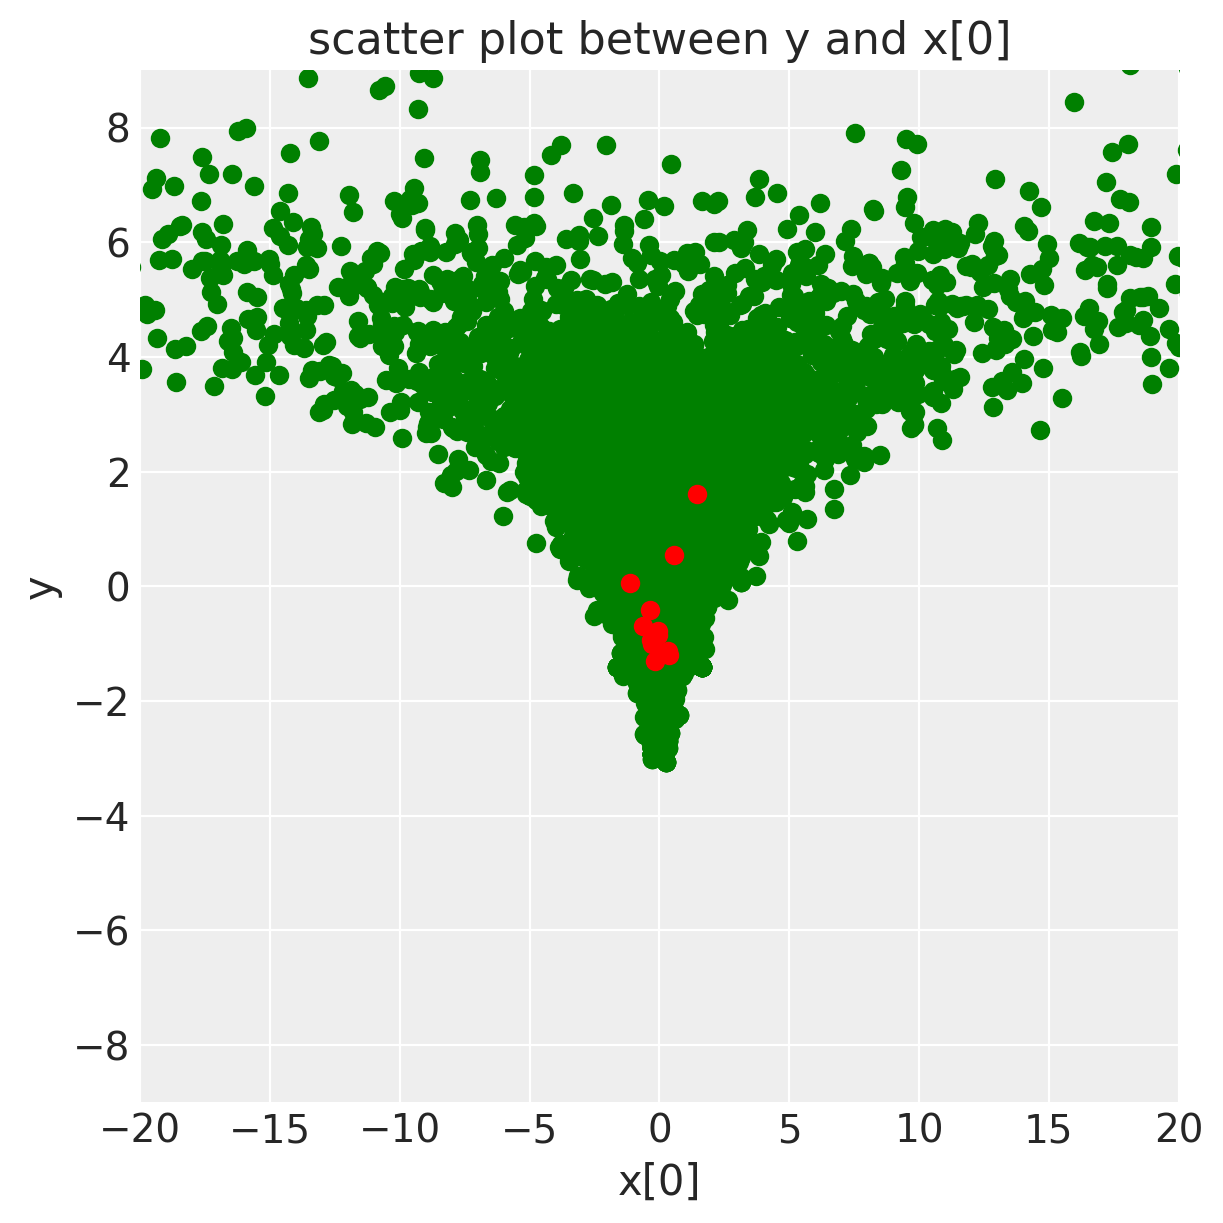

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[divergent == 0], y[divergent == 0], color='g')
plt.scatter(x0[divergent == 1], y[divergent == 1], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


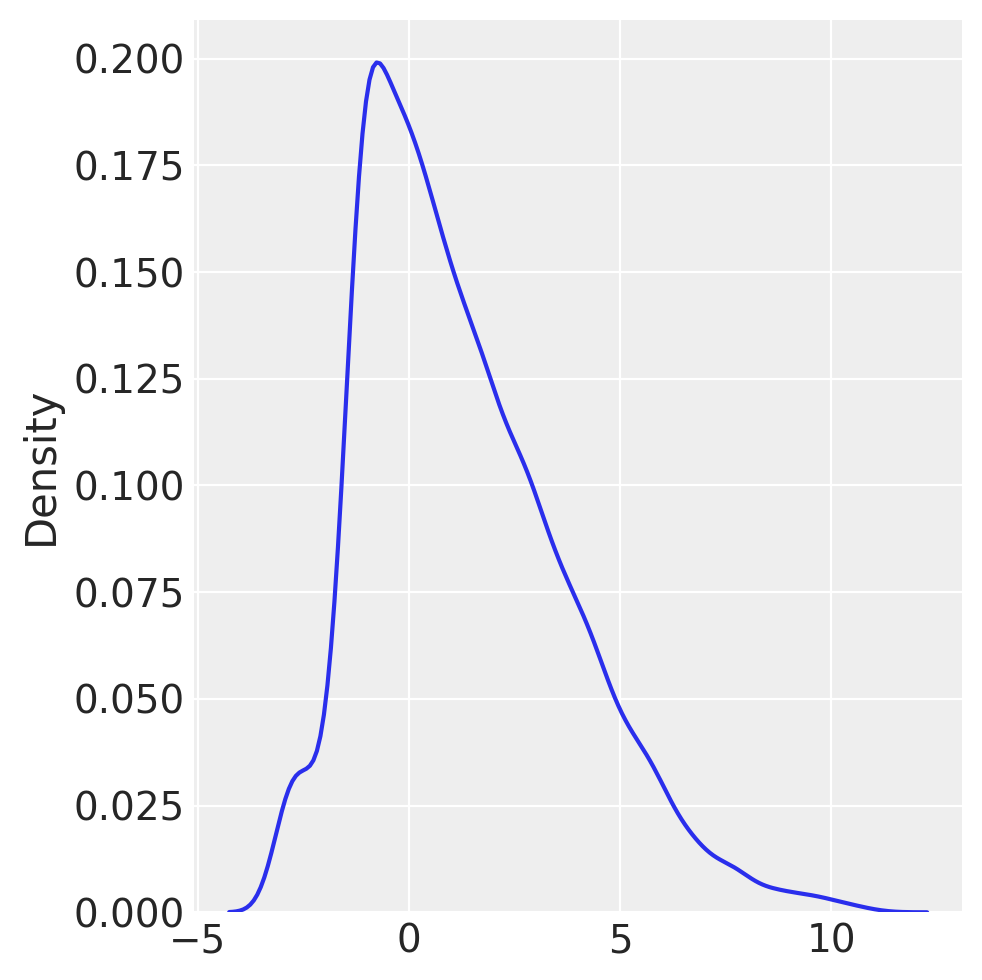

In [13]:
sns.displot(y, kind="kde")

## 5.4 実装方法 (2)
* これは、reparameterizationを使うことで改良された実装。
 * divergent transitionは起こらない。
 * $y$のサンプルのヒストグラムも正規分布の形を示す。

In [14]:
with pm.Model() as model_revised:
  y = pm.Normal("y", mu=0, sd=3)
  x_raw = pm.Normal("x_raw", mu=0, sd=1, shape=9)
  x = pm.Deterministic("x", (y/2).exp() * x_raw)

In [15]:
with model_revised:
    trace_revised = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


In [16]:
x0 = trace_revised['x'][:, 0]
y = trace_revised['y']
divergent = trace_revised['diverging']

Text(0.5, 1.0, 'scatter plot between y and x[0]')

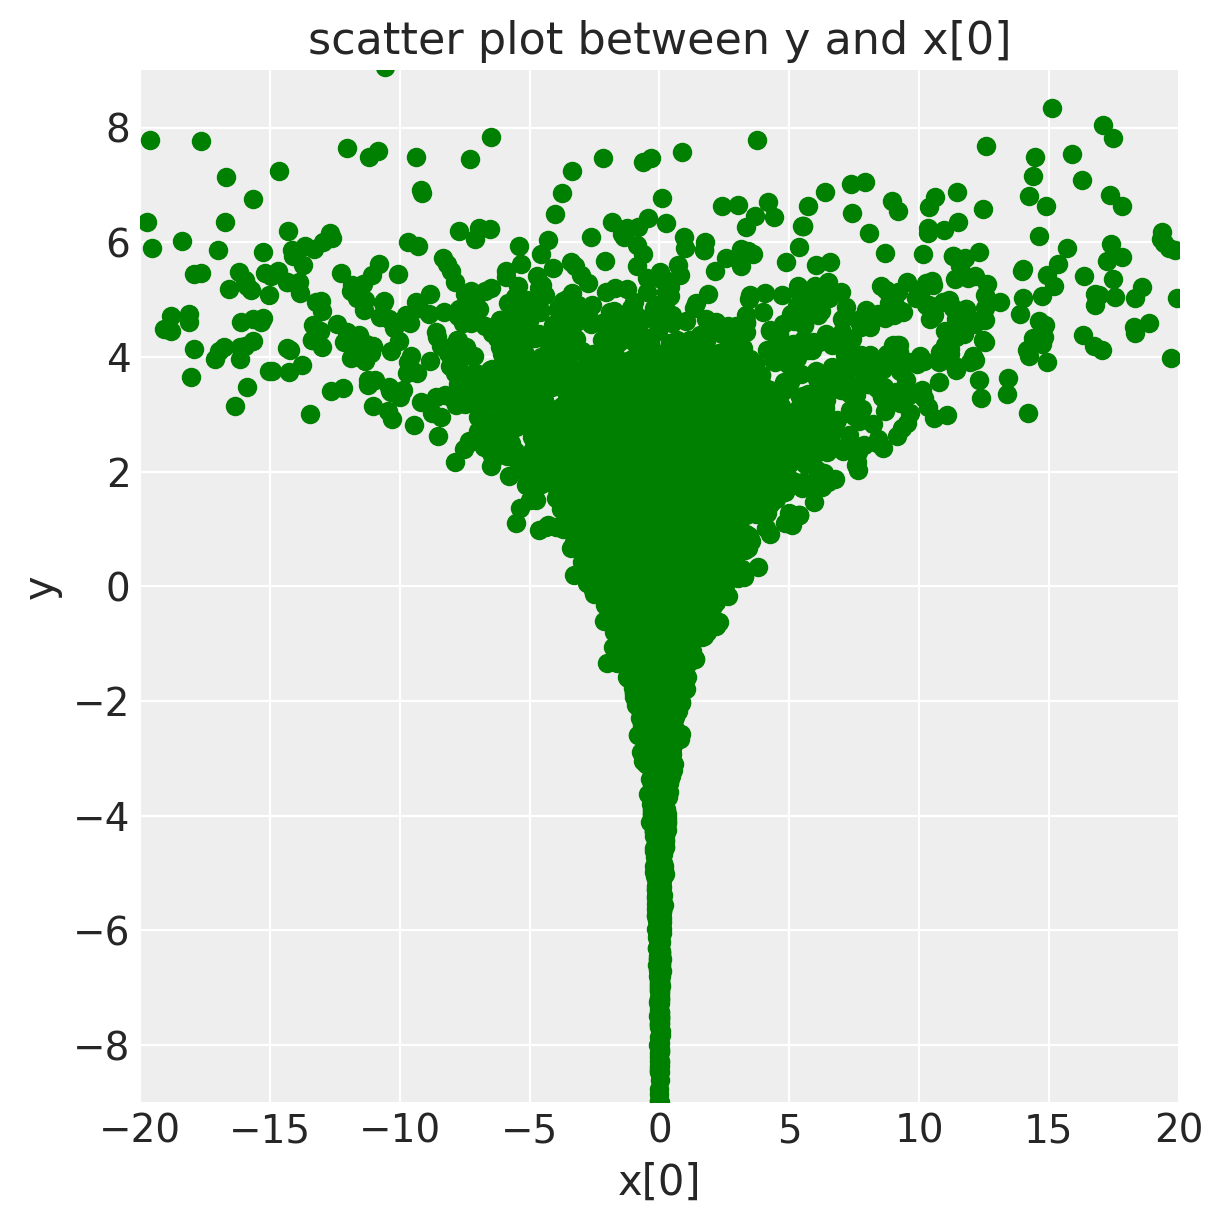

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[divergent == 0], y[divergent == 0], color='g')
plt.scatter(x0[divergent == 1], y[divergent == 1], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


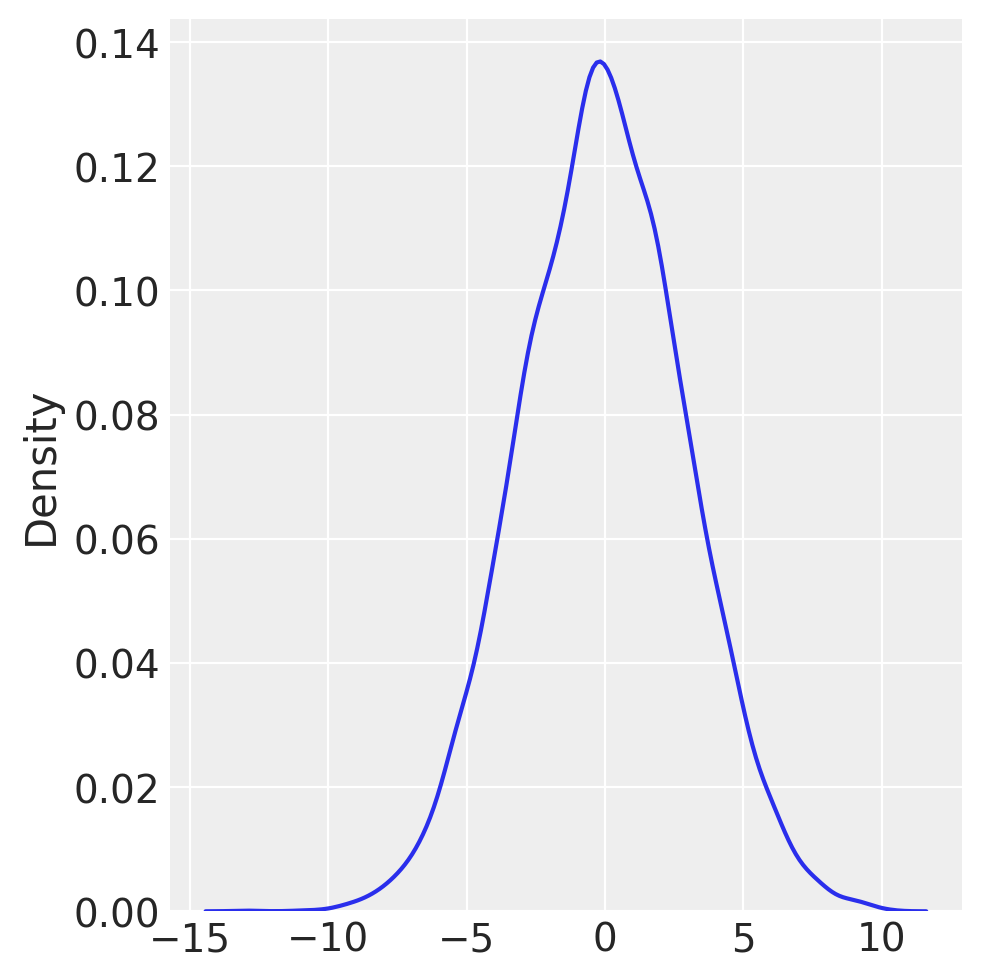

In [18]:
sns.displot(y, kind="kde")

## 5.5 The Eight Schools Model
* 下記Webページにある「A Centered Eight Schools Implementation」の実験を再現してみる。
 * https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html
 * arviz向けにコードを書き直した。

### 5.5.1 データセット

In [19]:
# Data of the Eight Schools Model
J = 8
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float)
# tau = 25.

### 5.5.2 モデル1
* これは良くないモデル
 * reparametrizationを使って後で改良する。

In [20]:
with pm.Model() as Centered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [21]:
with Centered_eight:
  short_trace = pm.sample(500, cores=2, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 6 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5595310854469553, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
az.rhat(short_trace)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 8)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu           float64 1.061
    theta        (theta_dim_0) float64 1.083 1.068 1.045 ... 1.093 1.021 1.077
    tau          float64 1.085

In [23]:
az.ess(short_trace)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 8)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu           float64 137.6
    theta        (theta_dim_0) float64 187.1 244.1 177.0 ... 173.3 147.3 240.1
    tau          float64 20.42

/usr/local/lib/python3.7/dist-packages/pymc3/plots/__init__.py:36: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  f"Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec78b68690>,
      dtype=object)

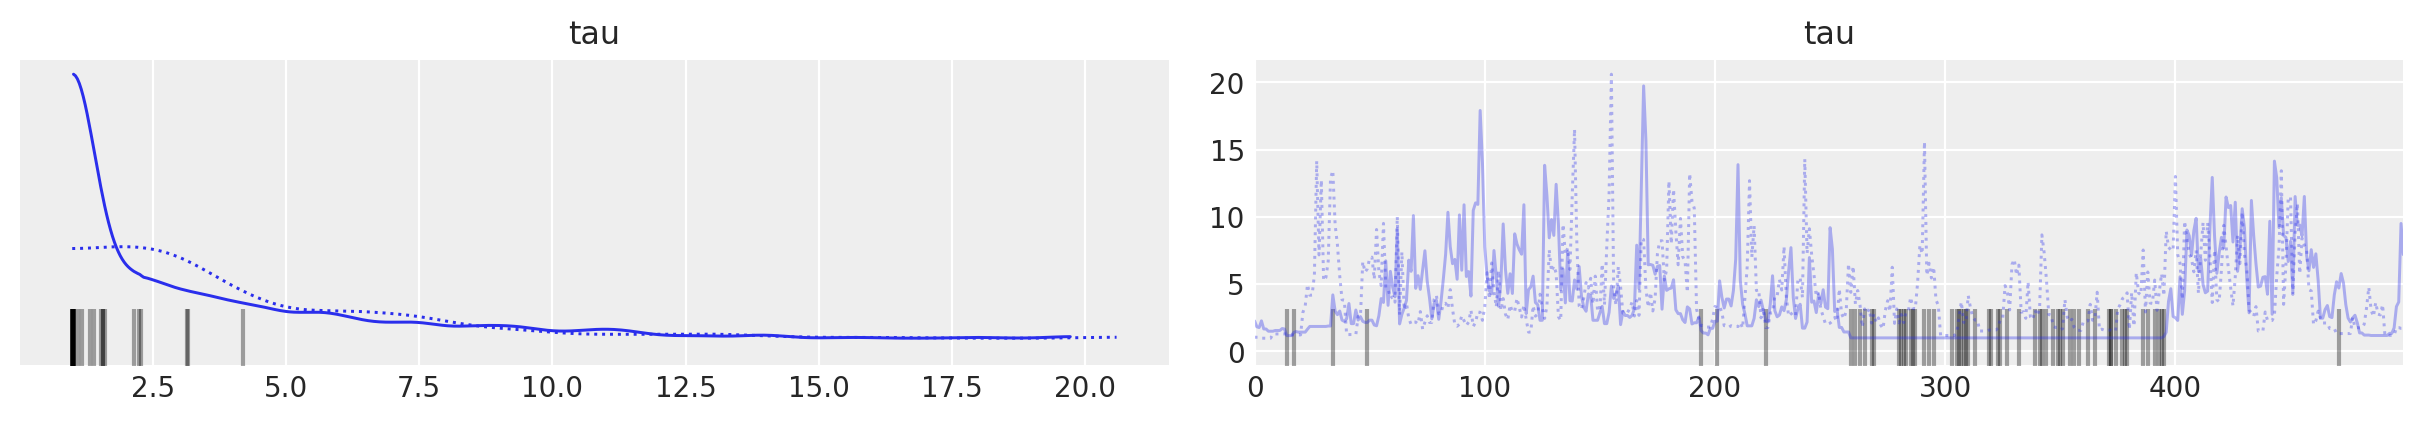

In [24]:
pm.traceplot(short_trace, varnames=['tau'])

In [25]:
short_trace.posterior['tau'].data.shape

(2, 500)

Text(0.5, 1.0, 'MCMC estimation of log(tau)')

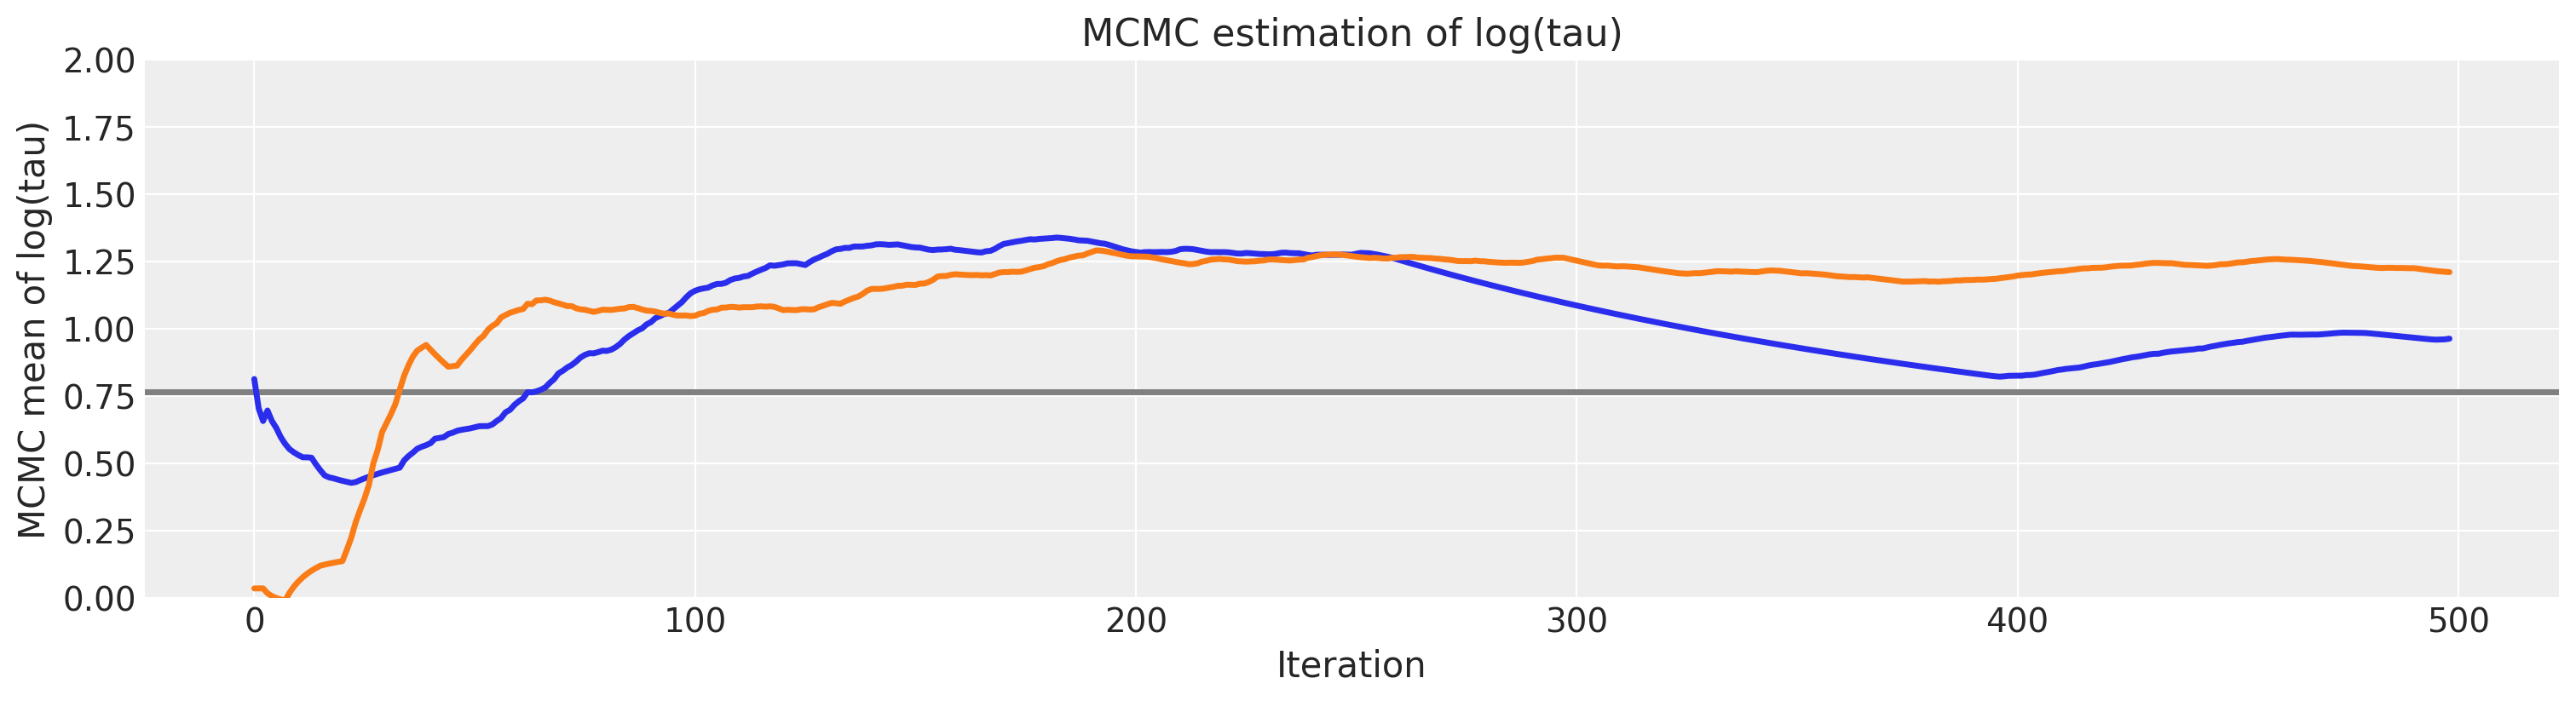

In [26]:
logtau = np.log(short_trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

In [27]:
short_trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 2, draw: 500)
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables: (12/13)
    step_size           (chain, draw) float64 0.325 0.325 0.325 ... 0.178 0.178
    energy_error        (chain, draw) float64 0.0 -0.4817 -0.5847 ... -1.943 0.0
    depth               (chain, draw) int64 4 2 2 5 3 1 3 2 ... 4 2 2 2 4 3 3 3
    diverging           (chain, draw) bool False False False ... False False
    perf_counter_diff   (chain, draw) float64 0.003639 0.001021 ... 0.001264
    mean_tree_accept    (chain, draw) float64 0.1927 0.8301 ... 0.8838 0.1676
    ...                  ...
    energy              (chain, draw) float64 55.66 56.23 54.1 ... 54.82 53.98
    process_time_diff   (chain, draw) float64 0.003639 0.001023 ... 0.001265
    lp                  (chain, draw) float64 -50.33 -52.35 ... -50.93 -50.93
    step_size_bar       (chain, draw) float64 0.3468 0.3468 ... 0.3011 0.3011
    perf_counter_start  (chain, draw) float64 4.577e+03 4.577e+03 ... 4.579e+03
    tree_size           (chain, draw) float64 15.0 3.0 3.0 23.0 ... 7.0 7.0 7.0
Attributes:
    created_at:                 2021-04-26T07:34:51.399677
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              6.054258346557617
    tuning_steps:               1000

In [28]:
short_trace.sample_stats.diverging.data.shape

(2, 500)

In [29]:
short_trace.posterior['mu'].data[short_trace.sample_stats.diverging.data]

array([ 1.42605118,  2.11762616,  2.82045075, -1.35244475,  3.64071857,
        7.33823266,  5.43879615,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  4.72949378,  4.72949378,  4.72949378,
        4.72949378,  4.72949378,  3.30915777,  3.10028237,  8.02755484,
        6.58794461,  6.03297685,  7.15602127,  3.22284407])

In [30]:
short_trace.sample_stats.diverging.data.shape

(2, 500)

In [31]:
chain_id = 0

In [32]:
# display the total number and percentage of divergent
divergent = short_trace.sample_stats.diverging.data[chain_id]
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(divergent)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 58
Percentage of Divergent 0.11600


In [33]:
short_trace.posterior['theta'][chain_id][:,0]

<xarray.DataArray 'theta' (draw: 500)>
array([ 3.94459701,  7.72246641,  7.24853154,  5.92741167,  0.18947569,
        0.18947569, -0.64827961, -0.64827961, -0.64827961,  0.70546574,
        0.70546574,  0.70546574, -0.06387158,  2.99911377,  0.90744631,
        0.90744631,  0.90744631,  1.11634371,  5.59820226,  2.91818151,
        2.91818151,  2.91818151,  2.91818151,  3.02337084,  2.71197423,
        2.71197423,  2.71197423,  2.71197423,  2.71197423,  2.71197423,
        2.71197423,  2.71197423,  3.66598178,  3.66598178,  1.556345  ,
        9.34411587,  0.70277617,  1.67873547,  0.76253678,  4.95480726,
        4.51502509,  5.72508859, -4.73520916, -4.73520916,  4.38515457,
        7.07410073,  4.04067168,  3.59857821, -1.10411424, -1.10411424,
        6.99008735,  6.99008735, -1.53728573,  1.86838652,  3.32635527,
        0.49993662, -7.34941645, 13.12564096,  7.80547019, -2.52661603,
       13.13735162,  8.43819114,  4.68604759,  9.15736594,  6.65779747,
        8.17219884, -2.53310469,  5.34140861,  6.29602624,  6.22339305,
       13.79247083, 14.3383913 , 12.331401  , 16.37919792, 13.01097747,
        2.86293793,  7.70333043,  4.54045791, 10.98644497,  9.90381635,
       10.66431127,  4.02147384, 10.08195455,  8.66131623, 15.11574089,
        0.54268845, 11.76398587, 10.41106015, -9.76051655, 18.63957134,
        5.0279648 ,  5.71260989,  1.42073858, 13.81278707, 10.02337504,
       22.14670958,  4.09911982, 15.46834664, 18.37137382,  9.19160972,
...
        7.5537682 ,  1.67008903, -5.73542558,  2.38521603, -4.1775946 ,
       16.43147509,  2.38712925, 23.09821674, -7.64152088, 18.83906233,
       17.46662851,  1.17197038, 11.86934532,  8.42954493,  7.37081856,
        9.59991683,  2.34597666,  7.5875025 ,  5.15622335, -6.86175391,
        9.00222432,  9.78919681, 16.78957216, 18.21384257,  0.83833446,
       17.70480419, 11.381904  , 10.10170998, 16.71291722,  9.32908934,
        6.78480241,  7.19392424, -1.69024387, 10.61547326,  2.31656306,
        0.91786229, 11.87989678, 10.40424558,  7.81987016,  8.89800027,
        7.08910143, -2.67176593,  4.50663224,  9.31314293,  4.74299887,
        7.11370263, 28.83923139,  8.34855256, 11.75424545,  9.23165412,
       11.6955438 ,  7.80295895, 19.29105025, 17.63259735,  8.46694394,
       10.2029004 , 18.38838784, -5.16535625,  9.69903708,  9.79955547,
       20.05068298, 11.69558837, 19.79818697,  2.56526364,  2.56526364,
        3.11283062,  0.52323481,  1.58413403,  2.41344316,  5.67471666,
        5.68524676,  5.97297621,  1.50221794, 13.5226597 ,  2.27800933,
        1.87046612,  2.99108356,  2.14758434,  4.78188796,  2.83530903,
       -0.7736367 , -0.7736367 , -0.55150169, -0.55150169, -0.55150169,
        1.55516841,  1.55516841,  1.55516841,  1.55516841,  1.55516841,
        1.55516841,  1.55516841,  1.55516841, -0.1341076 , -0.1341076 ,
        1.39556643, -2.94947752, 19.31326164,  6.28001966,  6.23414502])
Coordinates:
    chain        int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    theta_dim_0  int64 0

In [34]:
logtau.shape

(2, 500)

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

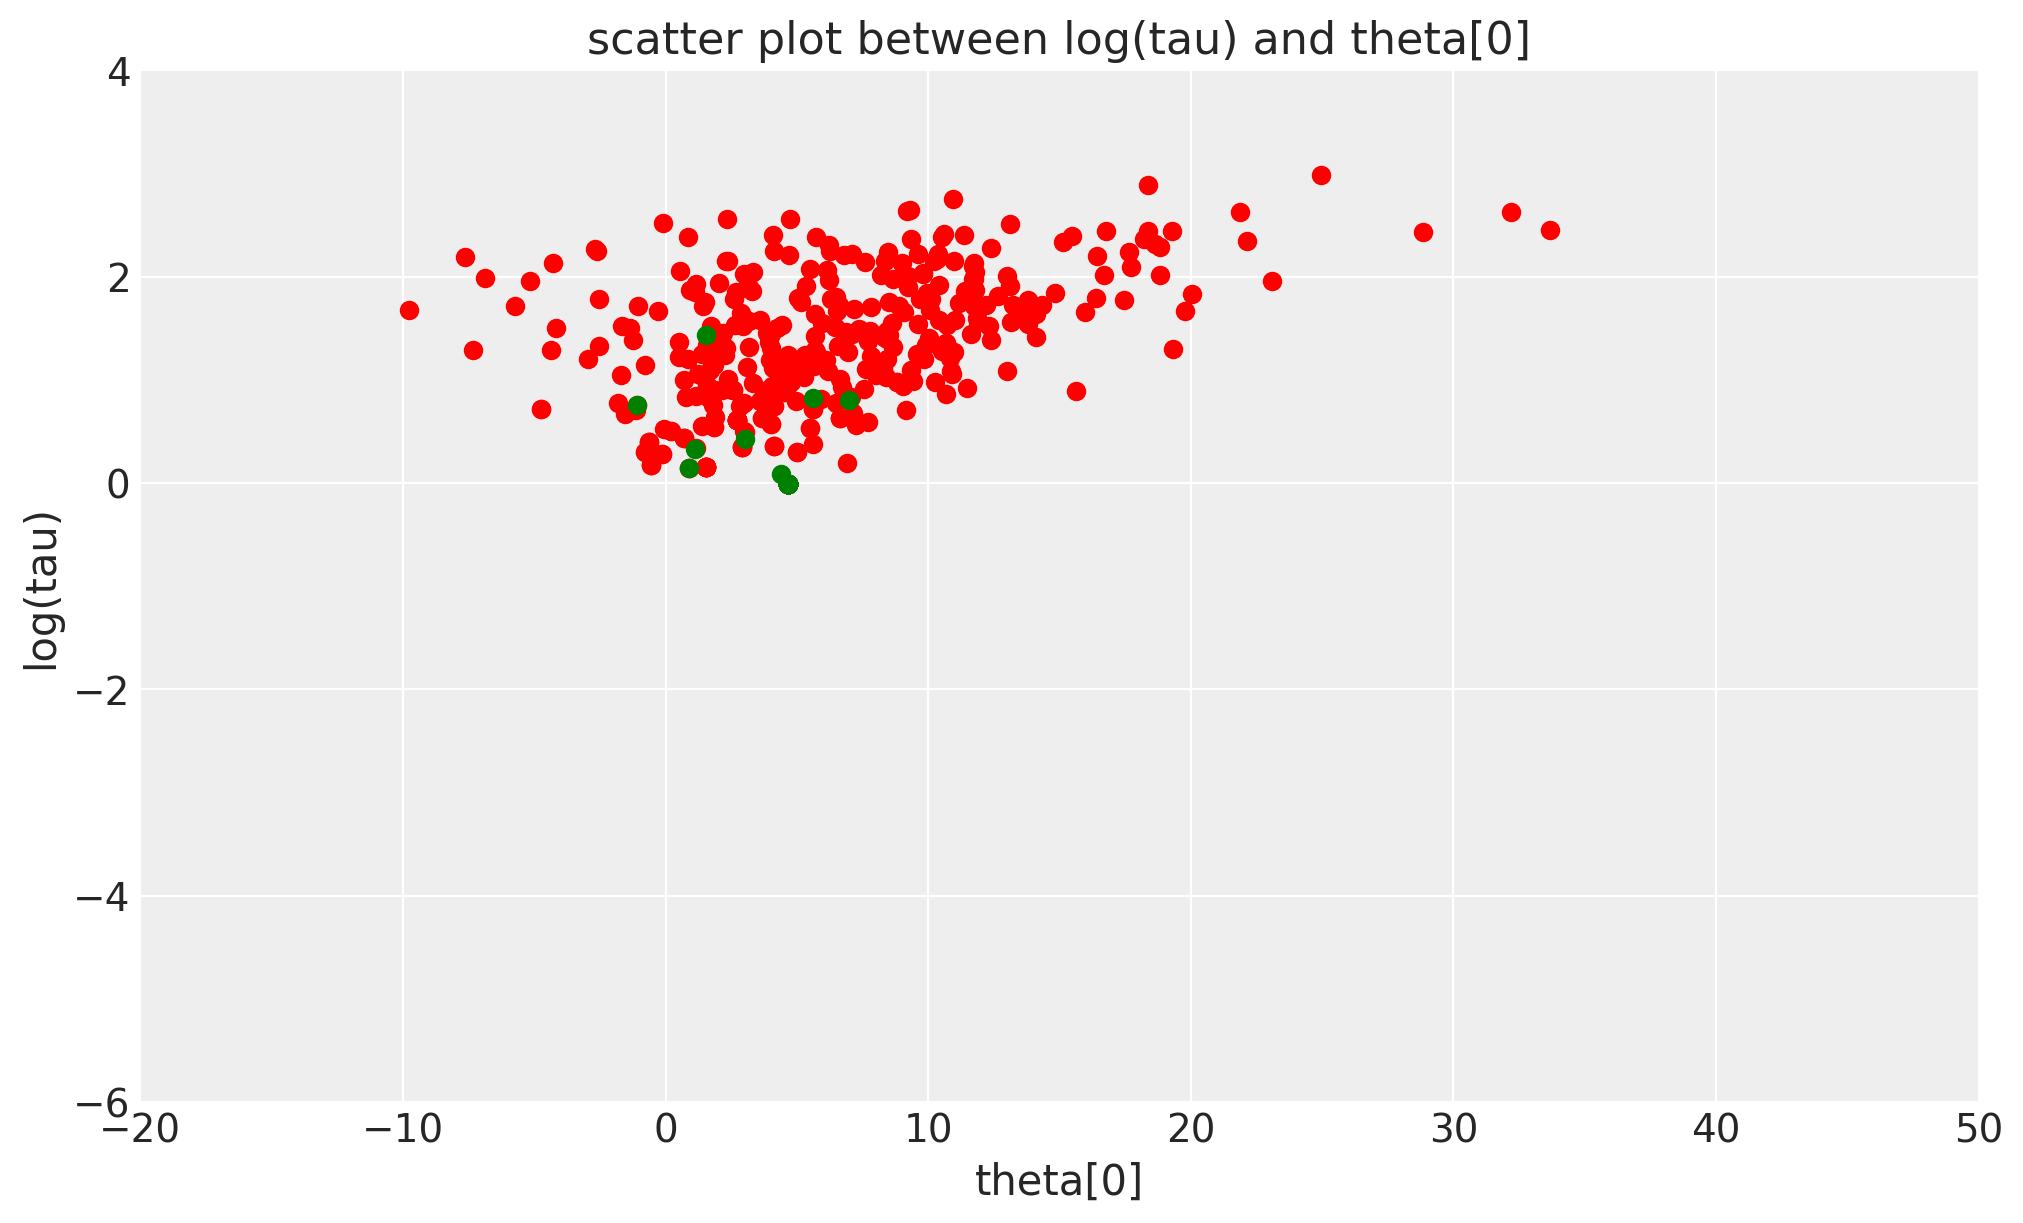

In [35]:
theta_trace = short_trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[chain_id][divergent == 0], color='r')
plt.scatter(theta0[divergent == 1], logtau[chain_id][divergent == 1], color='g')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

In [36]:
chain_id = 1

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

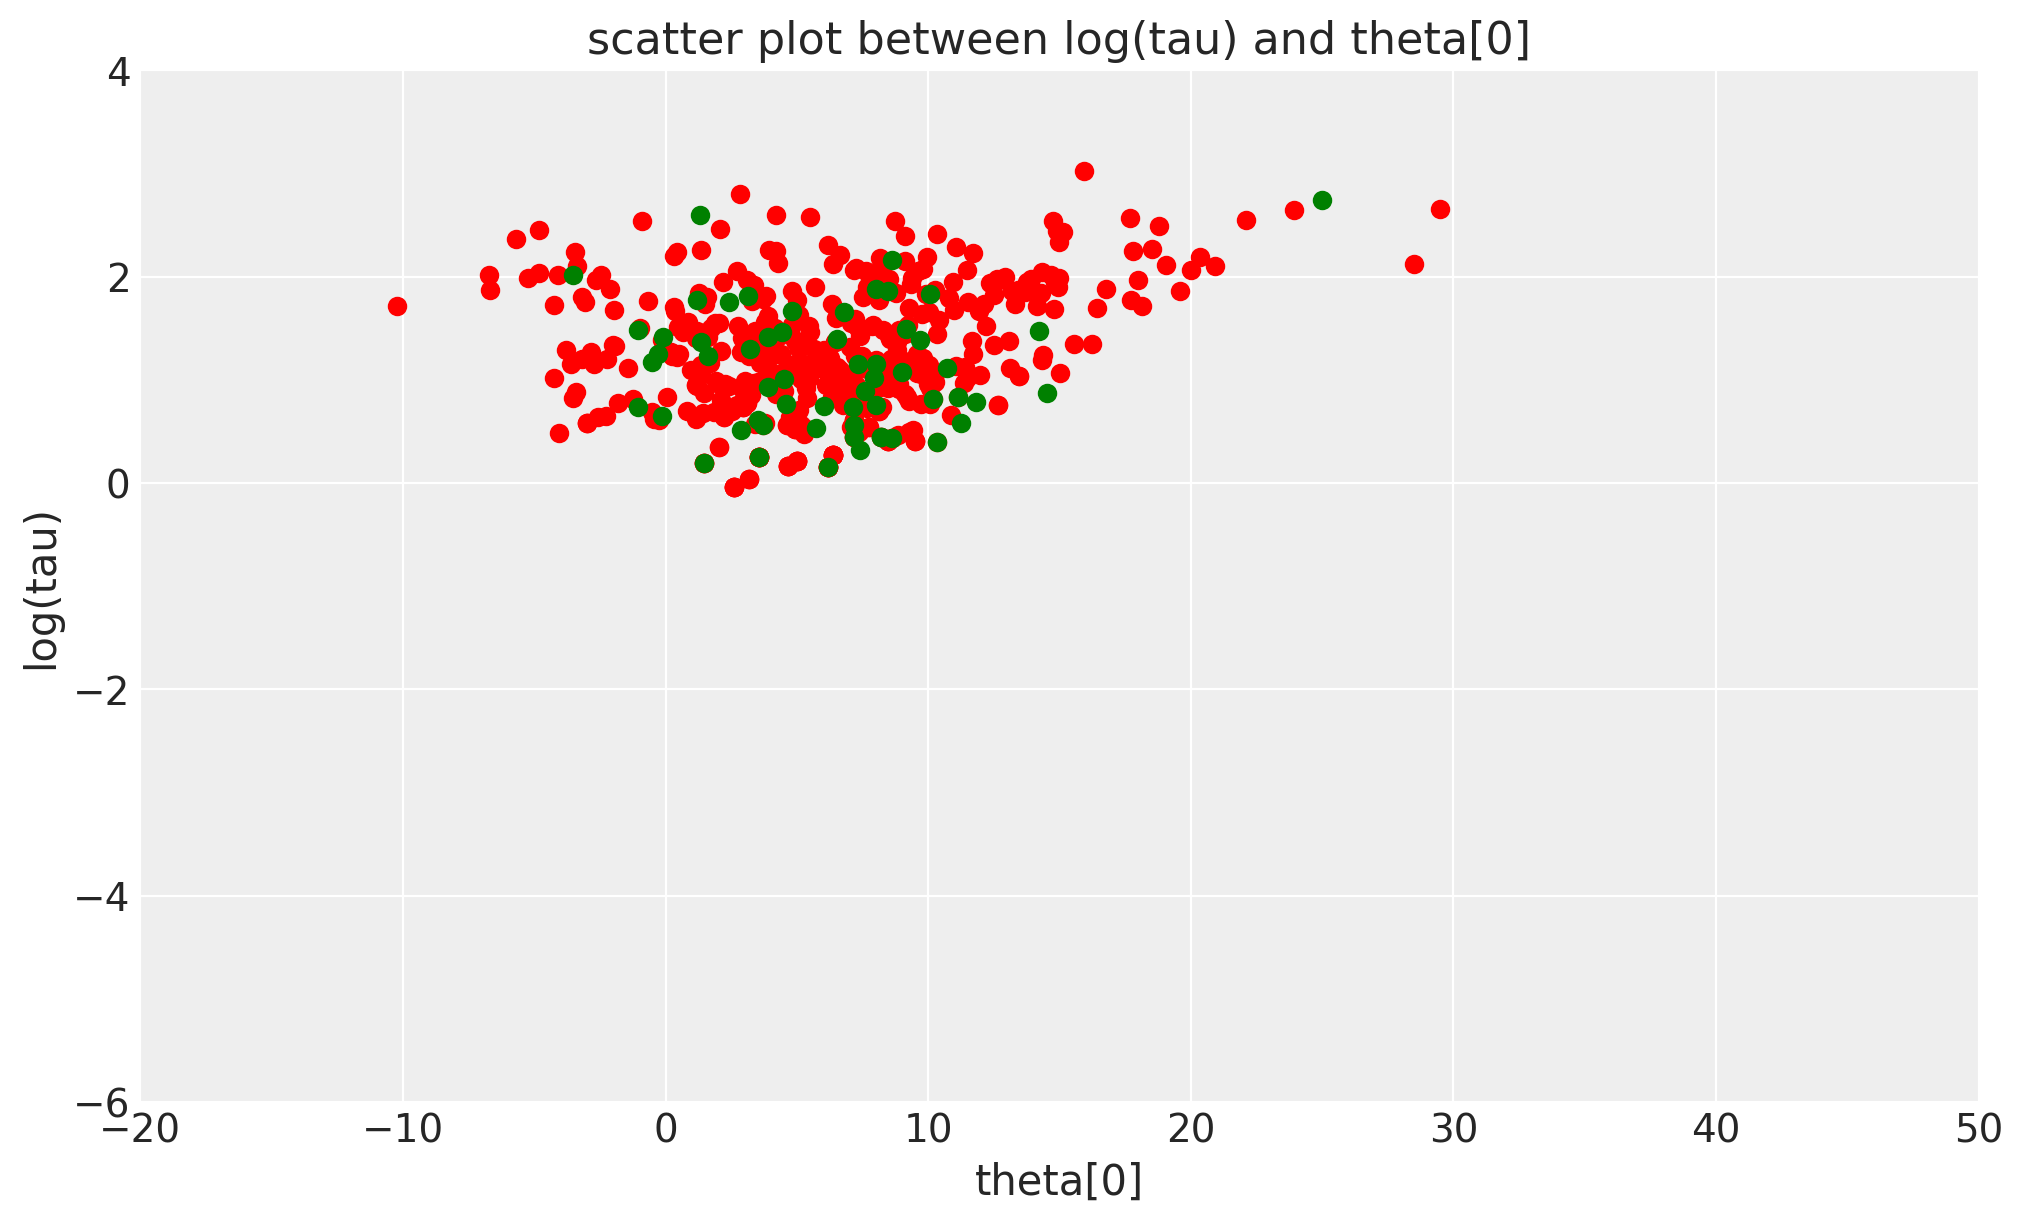

In [37]:
theta_trace = short_trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[chain_id][divergent == 0], color='r')
plt.scatter(theta0[divergent == 1], logtau[chain_id][divergent == 1], color='g')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

## 課題5
* 下記のWebページにある「A Non-Centered Eight Schools Implementation」の実験を再現してみよう。
 * https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html

### 5.5.3 モデル2
* A Non-Centered Eight Schools Implementation

In [38]:
with pm.Model() as NonCentered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
  theta = pm.Deterministic('theta', mu + tau * theta_tilde) # ここでreparametrizationを使用
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

* 以下、Webページの説明に従って実験を再現してみよう。